<a href="https://colab.research.google.com/github/RandhirGawai/NextWorkPredication/blob/main/Next_Word_Predication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [259]:
import numpy as np
np.random.seed(42)
import tensorflow as tf

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams


In [260]:
path ='/content/drive/MyDrive/LnB project/RNN Project/1661-0.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 581888


In [261]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [262]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print(len(sentences))

193950


In [263]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [264]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               103424    
                                                                 
 dense_3 (Dense)             (None, 73)                9417      
                                                                 
 activation_3 (Activation)   (None, 73)                0         
                                                                 
Total params: 112,841
Trainable params: 112,841
Non-trainable params: 0
_________________________________________________________________


In [265]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=512, epochs=10, shuffle=True).history

Epoch 1/10
360/360 [==============================] - 228s 625ms/step - loss: 2.1962 - accuracy: 0.3658 - val_loss: 2.1959 - val_accuracy: 0.3984
Epoch 2/10
360/360 [==============================] - 204s 566ms/step - loss: 1.7360 - accuracy: 0.4793 - val_loss: 2.0671 - val_accuracy: 0.4295
Epoch 3/10
360/360 [==============================] - 182s 505ms/step - loss: 1.5889 - accuracy: 0.5192 - val_loss: 2.0382 - val_accuracy: 0.4339
Epoch 4/10
360/360 [==============================] - 193s 536ms/step - loss: 1.5030 - accuracy: 0.5428 - val_loss: 2.0089 - val_accuracy: 0.4500
Epoch 5/10
360/360 [==============================] - 206s 570ms/step - loss: 1.4441 - accuracy: 0.5584 - val_loss: 2.0144 - val_accuracy: 0.4591
Epoch 6/10
360/360 [==============================] - 169s 469ms/step - loss: 1.4003 - accuracy: 0.5701 - val_loss: 2.0018 - val_accuracy: 0.4548
Epoch 7/10
360/360 [==============================] - 164s 454ms/step - loss: 1.3673 - accuracy: 0.5780 - val_loss: 1.9982 -

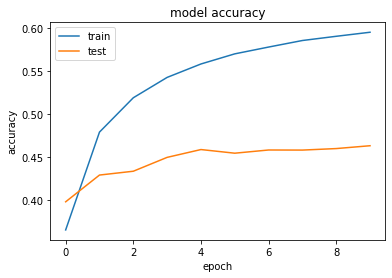

In [266]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

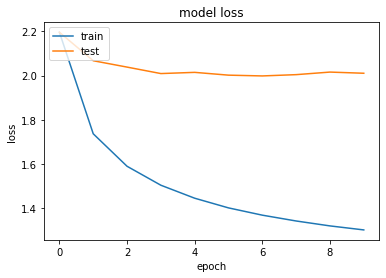

In [267]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [276]:
model.save('keras_model.h5')
pickle.dump(history, open("history.p", "wb"))

model = load_model('keras_model.h5')
history = pickle.load(open("history.p", "rb"))

In [277]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [278]:
prepare_input("This is an example of input for our LSTM".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [279]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [280]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [281]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    print("gf")
    preds = model.predict(x, verbose=0)[0]
    print("fg")
    next_indices = sample(preds, n)
    print(text)
    print(predict_completion(text[1:]))
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [297]:
quotes = [
    
    "and those who were seen dancing were tho",
    
]

In [298]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
   # print()

and those who were seen dancing were tho
gf
fg
and those who were seen dancing were tho
e 
['ught ', 'se ', 'om ', 're ', 'ne ']
